## TP 3 - Visión por Computadora 1

### Carrera de Especialización en Inteligencia Artificial - Cohorte 17

### Autora: Micozzi, María Luz - a1707

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

In [1]:
# imports
import numpy as np
import cv2 as cv

import sys
sys.path.append('../utils')
from functions import read_images, show_images

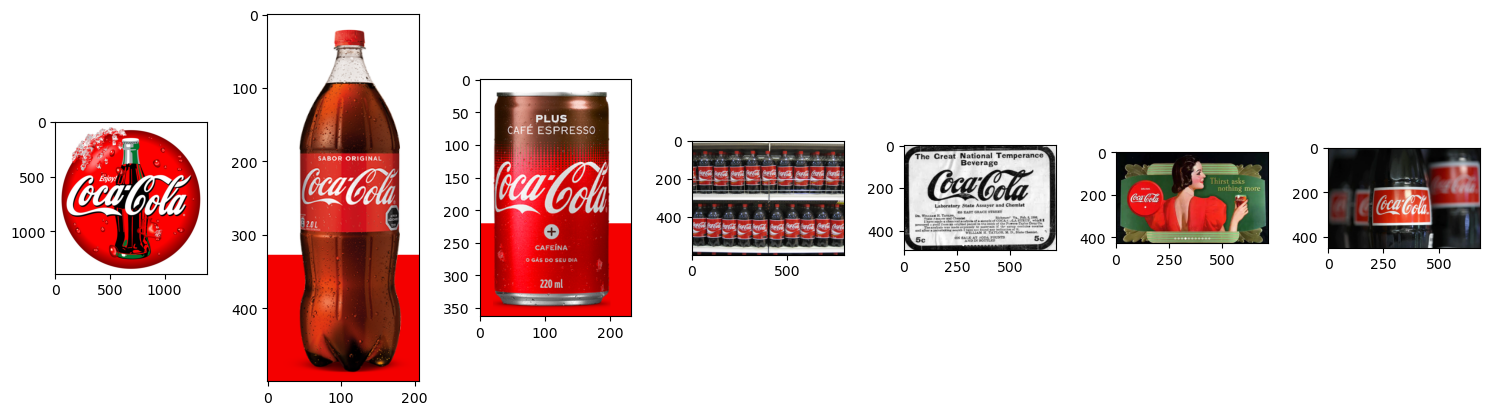

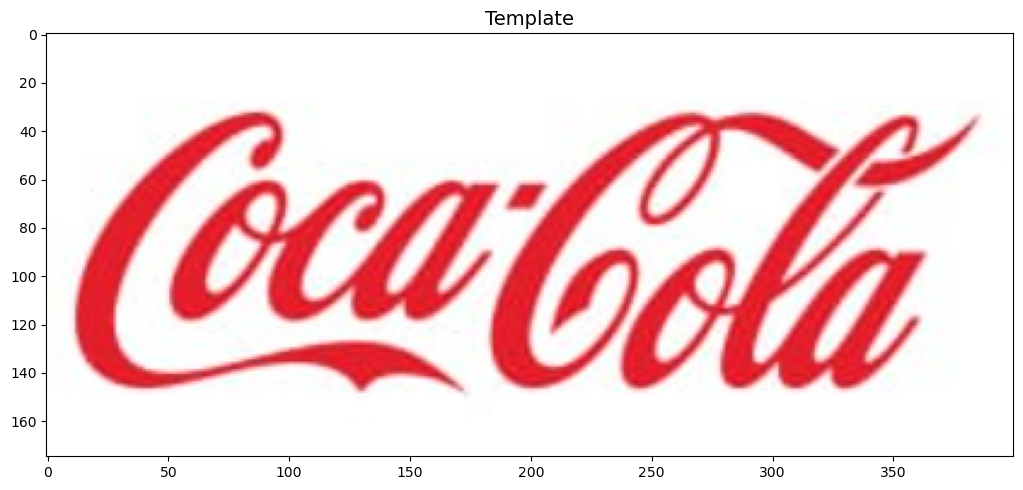

In [2]:
# leemos y mostramos las imágenes y el template
images = read_images('images')
show_images(images, [])
templates = read_images('template')
template = templates[0]
show_images(templates, ['Template'])

Vemos que las imágenes y el template tienen diferentes escalas, lo cual es un factor a tener en cuenta para la correcta detección.
Por otro lado, viendo las diferencias en intensidad, sombras e iluminación aplicaremos Canny para hacer el matching utilizando los bordes.

### 1. Obtener una detección del logo en cada imagen sin falsos positivos

##### Primero exploramos aplicando los 6 métodos de match template sobre las distintas imágenes para seleccionar el mejor método.
##### Se probarán distintas escalas para cada imagen para buscar el mejor resultado para cada método.

In [3]:
def mark_template(image: np.ndarray, match: list, show_score: bool = True) -> np.ndarray:
    """
    Recibe una imagen y los datos de ubicación donde se detectó el template.
    Devuelve la imagen con el template marcado con un recuadro y el valor de detección.

    :param image: Imagen en la cual se quiere marcar el template
    :type image: np.ndarray
    :param match: Datos de escala y ubicación donde se detectó el template
    :type match: list
    :param show_score: Determina si se debe mostrar o no el score. Por defecto True.
    :type show_score: bool
    
    :returns: Imagen con el temprante marcado
    :rtype: np.ndarray
    """
    
    value, location, shape_temple, scale = match
    x1, y1 = int(location[0]/scale), int(location[1]/scale)    
    h, w = int(shape_temple[0]/scale), int(shape_temple[1]/scale)
    x2, y2 = x1 + w, y1 + h

    cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    if (show_score) :
        text_y = y1 - 10 if y1 - 10 > 0 else y1 + 20
        cv.putText(image, f"{value:.2f}", (x1, text_y), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)

    return image

In [4]:
def match_template_single_detection_test_methods(img: np.ndarray, template: np.ndarray, methods: list) -> None:
    """
    Recibe una imagen, un template y una lista de methods de match template.
    Prueba los distintos métodos para comparar.

    :param img: Imagen en la cual se quiere detectar el template
    :type img: np.ndarray
    :param template: Template a detectar en la imagen
    :type template: np.ndarray
    :param methods: Lista de methods de match template
    :type methods: list
    """

    images = []

    # conviertimos el template a escala de grises y aplicamos Canny
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    template_edges = cv.Canny(template_gray, 100, 200, L2gradient=True)
    
    # iteramos sobre los distintos metodos de match template
    for method in methods :

        # conviertimos la imagen a escala de grises
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # definimos las escalas
        h_image, w_image, _ = img.shape
        h_template, w_template  = template_edges.shape
        max_scale = 5.0
        min_scale = max(h_template / h_image, w_template / w_image)
        scales = np.linspace(min_scale, max_scale, 100)

        best_results = []

        # iteramos sobre todas las escalas para buscar el mejor resultado
        for scale in scales:
            
            # escalamos y aplicamos Canny a la imagen
            img_scaled = cv.resize(img_gray, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
            img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)
            
            # aplicamos matchTemplate y buscamos el mejor resultado según el método usado

            result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            if method in ['TM_SQDIFF', 'TM_SQDIFF_NORMED']:
                best_match_value = min_val
                best_match_location = min_loc
                if best_results == [] or best_match_value < best_results[0]:
                    best_results = [best_match_value, best_match_location, (template_edges.shape), scale]
            else:
                best_match_value = max_val
                best_match_location = max_loc
                if best_results == [] or best_match_value > best_results[0]:
                    best_results = [best_match_value, best_match_location, (template_edges.shape), scale]
            
        # agregamos el borde a la imagen marcando donde se detectó el template
        img_plot = mark_template(img.copy(), best_results, show_score=False)
        images.append(img_plot)

    # gráficamos las imágenes para los distintos métodos, mostrando donde se detectó el template
    show_images(images, methods)

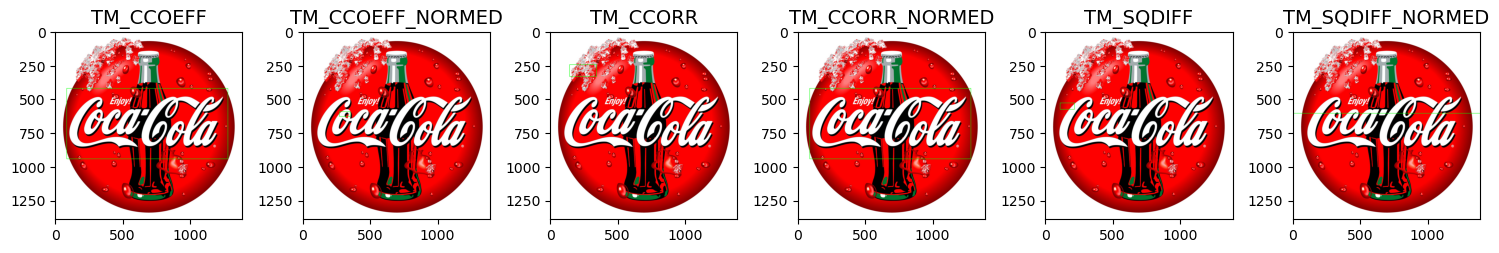

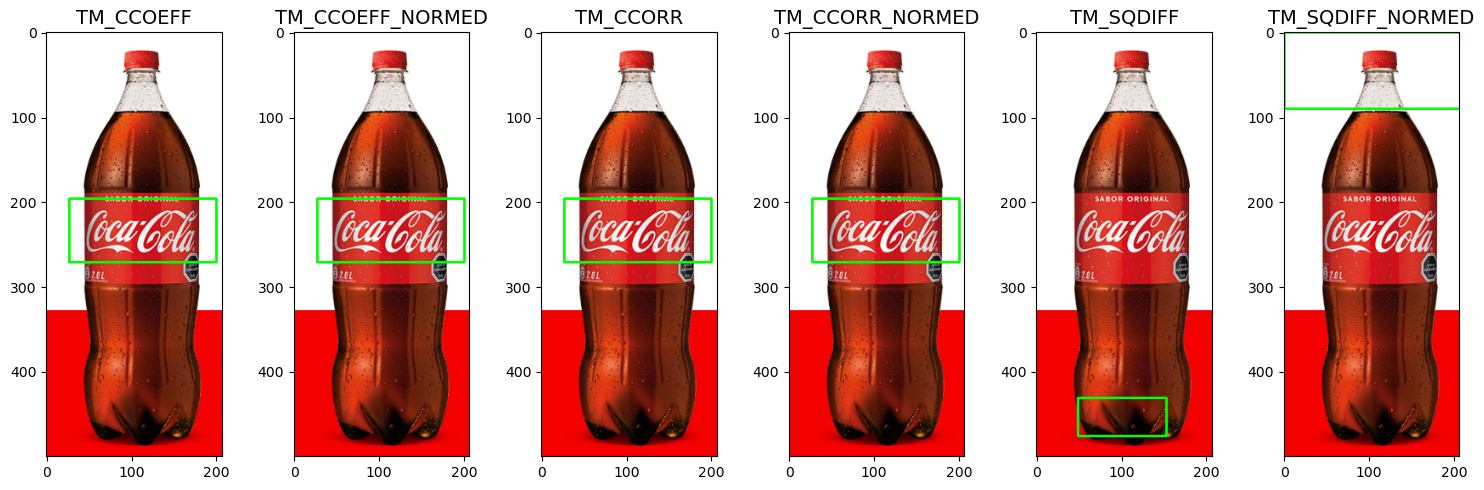

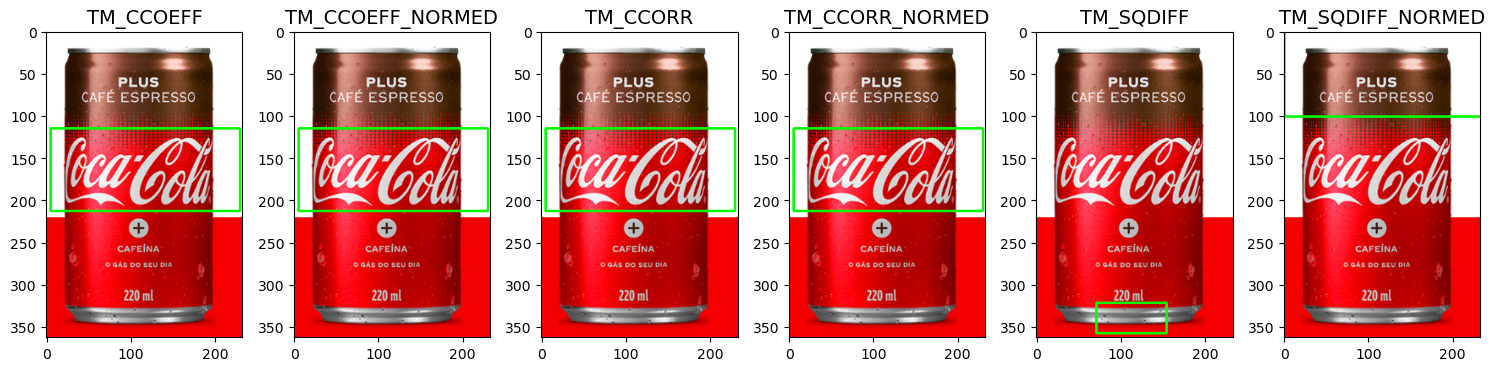

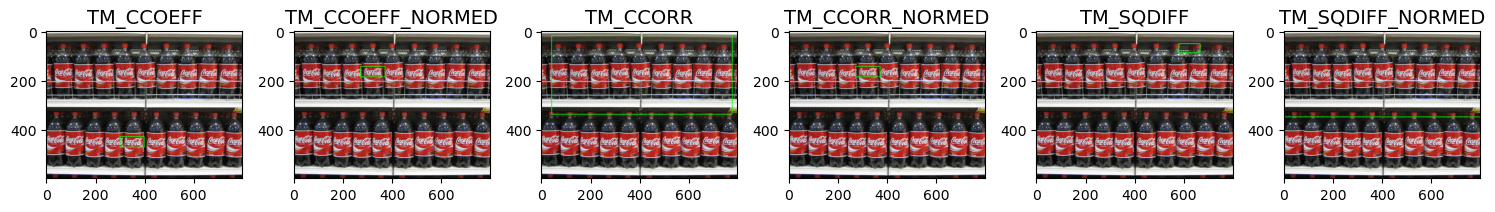

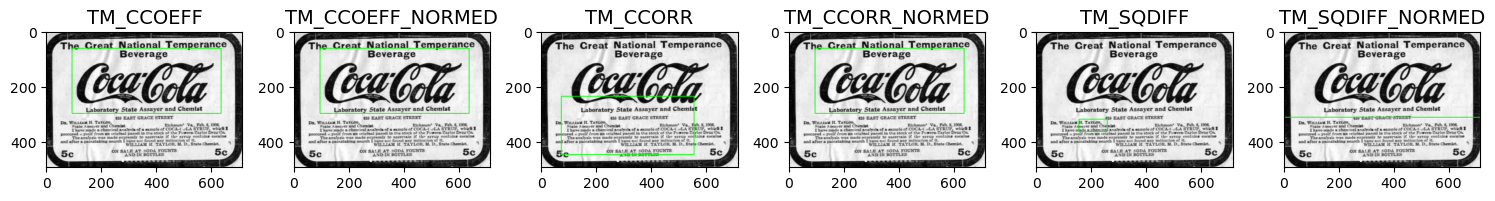

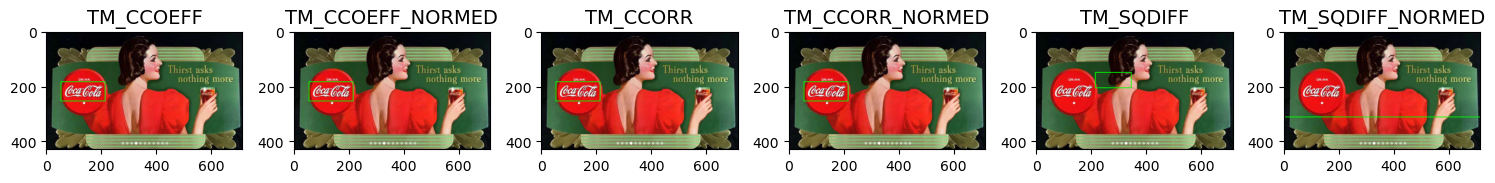

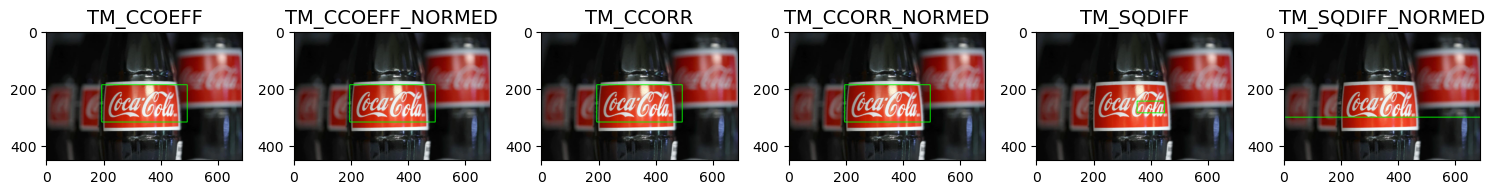

In [5]:
for img in images:
   match_template_single_detection_test_methods(img, template, methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED'])

Podemos observar que los métodos TM_CCOEFF y TM_CCORR_NORMED dieron buenos resultados para la detección sin falsos positivos para todas las imágenes.
Vamos a quedarnos con el método TM_CCOEFF.

##### Aplicamos el método de detección utilizando TM_CCOEFF

In [6]:
def  match_template_single_detection(img: np.ndarray, template: np.ndarray, method: str = 'TM_CCOEFF') -> None:
    """
    Recibe una imagen y un template a detectar en dicha imagen.
    (Detección única)

    :param img: Imagen en la cual se quiere detectar el template
    :type img: np.ndarray
    :param template: Template a detectar en la imagen
    :type template: np.ndarray
    :param method: Método a aplicar para matchTemplate. Por defecto TM_CCOEFF
    :type method: str
    """

    # conviertimos el template a escala de grises y aplicamos Canny
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    template_edges = cv.Canny(template_gray, 100, 200, L2gradient=True)

    # conviertimos la imagen a escala de grises
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
    # definimos las escalas
    h_image, w_image, _ = img.shape
    h_template, w_template  = template_edges.shape

    max_scale = 5.0
    min_scale = max(h_template / h_image, w_template / w_image)
    scales = np.linspace(min_scale, max_scale, 100)

    best_results = []

    # iteramos sobre todas las escalas para buscar el mejor resultado
    for scale in scales:
            
        # escalamos y aplicamos Canny a la imagen
        img_scaled = cv.resize(img_gray, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)
            
        # aplicamos matchTemplate y buscamos el mejor resultado

        result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
        _, max_val, _, max_loc = cv.minMaxLoc(result)
        
        if best_results == [] or max_val > best_results[0]:
            best_results = [max_val, max_loc, (template_edges.shape), scale]
            best_img_edges = img_edges
            
    # agregamos el borde a la imagen marcando donde se detectó el template y el score
    img_plot = mark_template(img.copy(), best_results)

    # gráficamos
    show_images([best_img_edges, img_plot], [f'Processed image - Scale: {best_results[3]:.2f}', f'Match template - Score: {best_results[0]:.2f}'])

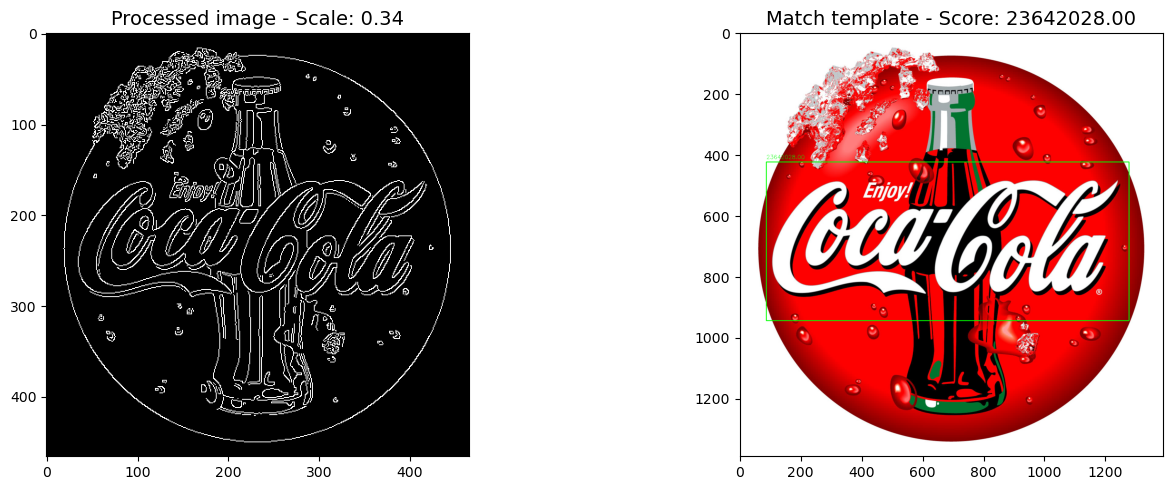

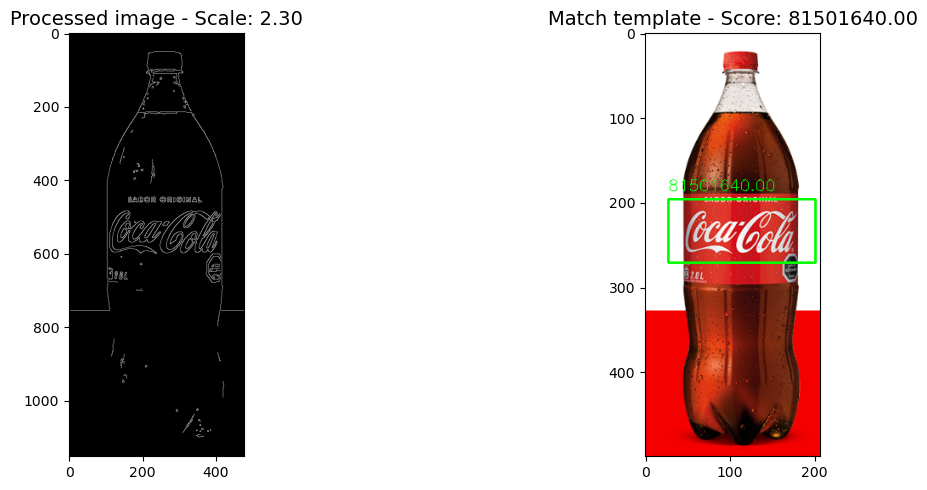

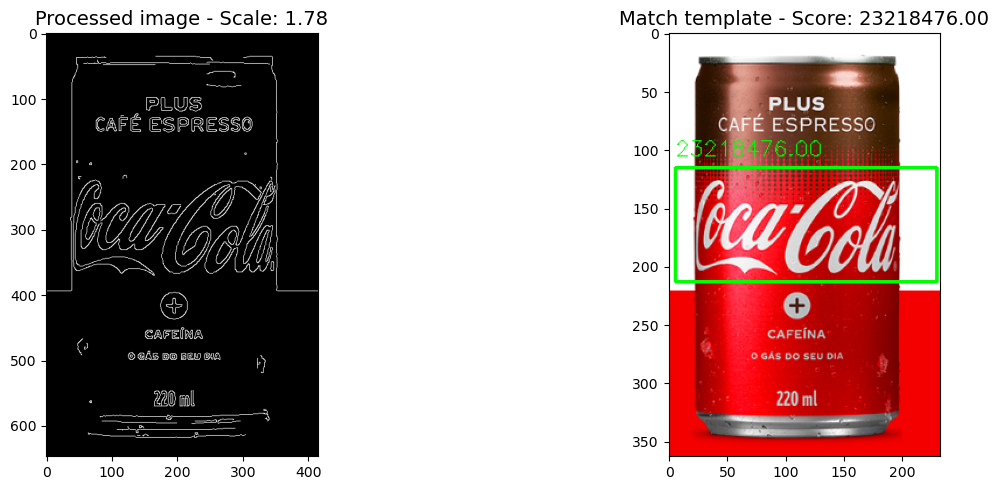

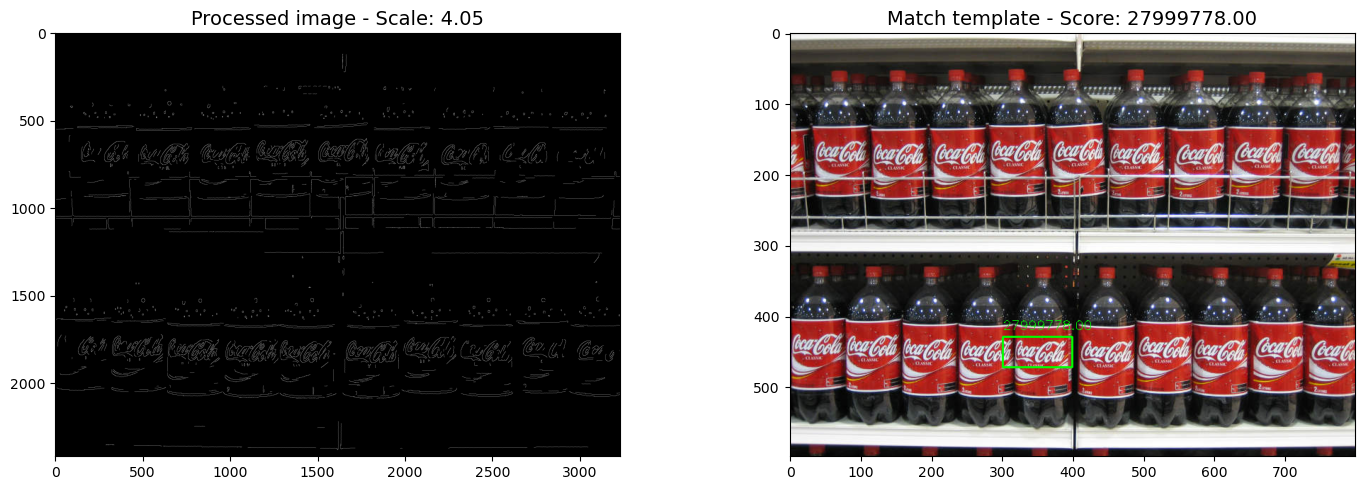

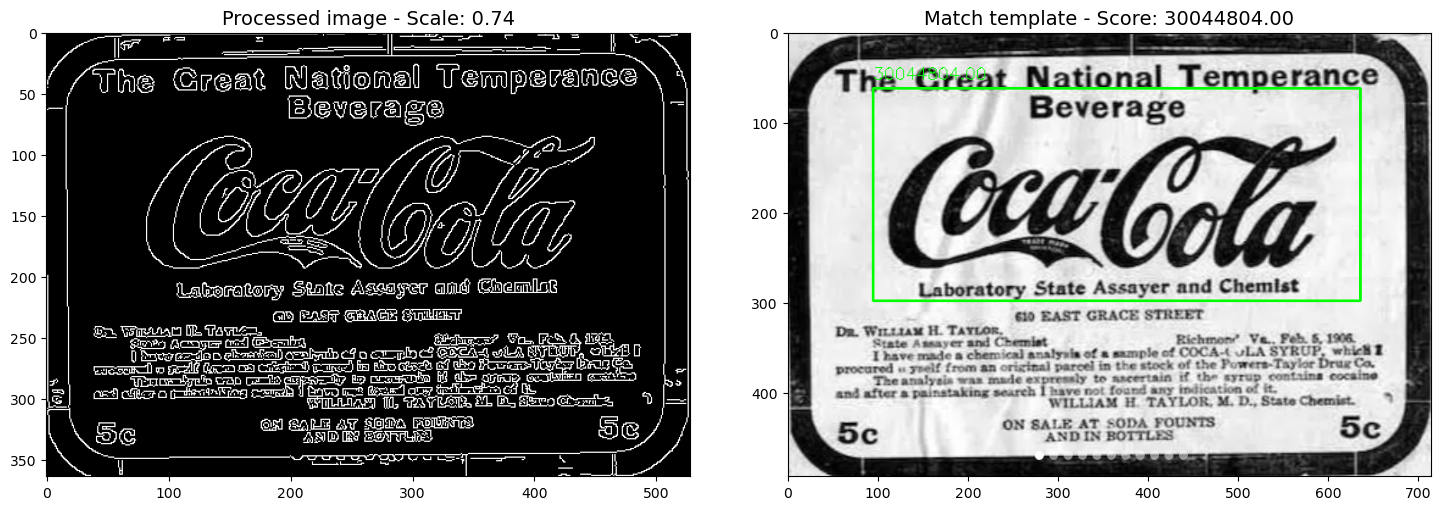

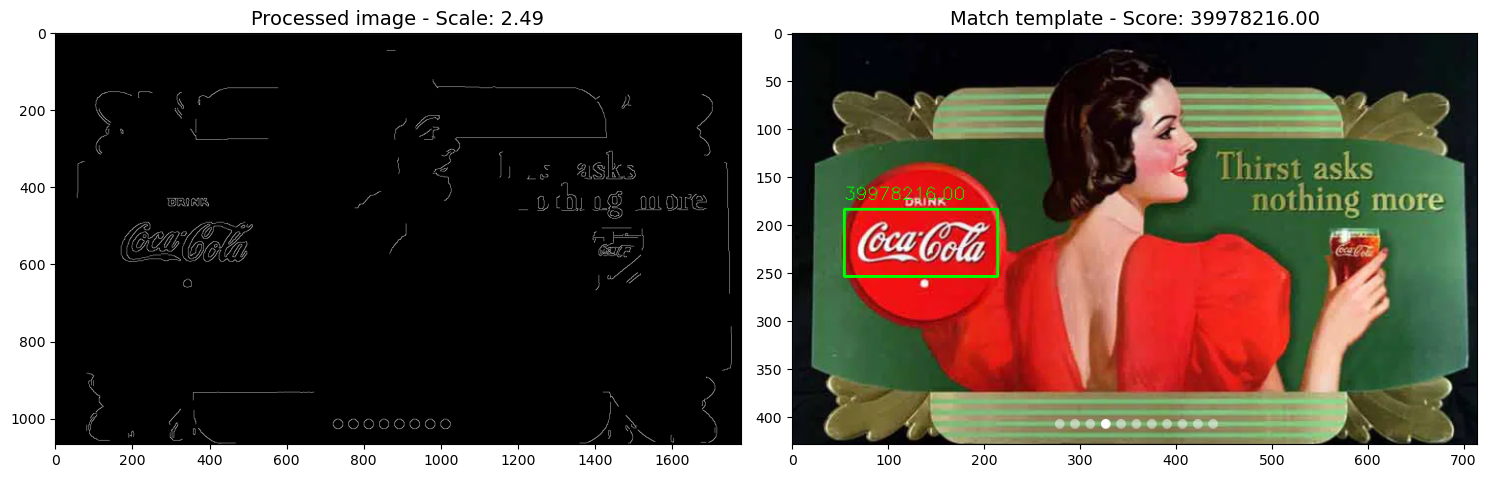

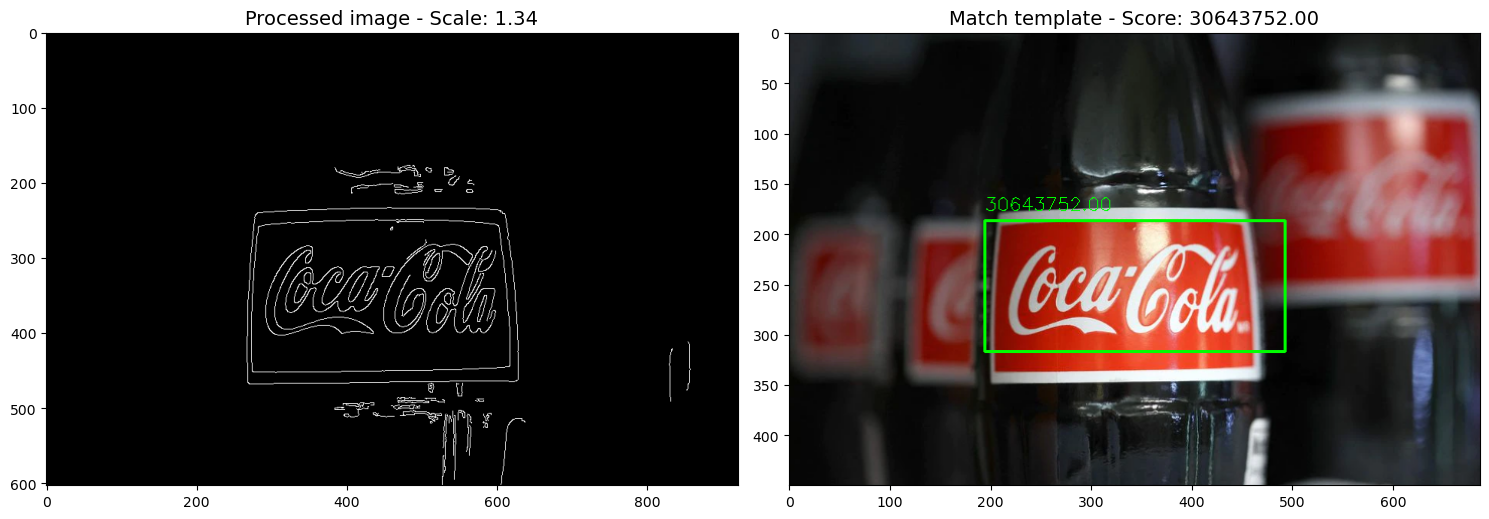

In [7]:
for img in images:
     match_template_single_detection(img, template)

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

En base a los resultados del punto anterior volvemos a utilizar TM_CCOEFF y tomamos la escala que mejor funcionó para la imagen coca_multi.

Además, se utilizará el algoritmo Non-Maximum Suppression para eliminar las superposiciones

In [22]:
def non_maximum_suppression(boxes: list, scores: list, threshold: float = 0.2) -> list:
    """
    Aplica Non-Maximum Suppression (NMS) para eliminar detecciones duplicadas.
    
    :param boxes: Lista de cajas delimitadoras
    :type boxes: list of tuples
    :param scores: Lista de valores de coincidencia para cada caja
    :type scores: list of floats
    :param threshold: Umbral de IoU para decidir si dos cajas se solapan. Por defecto 0.2
    :type threshold: float
    :return: Lista de índices de las detecciones seleccionadas
    :rtype: list
    """
    if len(boxes) == 0:
        return []

    # convertimos a arrays numpy
    boxes = np.array(boxes)
    scores = np.array(scores)

    # coordenadas de las cajas
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # áreas de las cajas
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # ordenamos las cajas por puntaje (de mayor a menor)
    order = scores.argsort()[::-1]

    keep = []  # lista de índices a mantener

    while order.size > 0:
        i = order[0]  # índice de la caja con mayor puntaje
        keep.append(i)

        # coordenadas de las intersecciones con las demás cajas
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # anchura y altura de la intersección
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # área de la intersección
        inter = w * h

        # IoU (Intersection over Union)
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        # mantenemos sólo las cajas con IoU menor al umbral
        inds = np.where(iou <= threshold)[0]
        order = order[inds + 1]

    return keep


In [23]:
def match_template_multiple_detections(img: np.ndarray, template: np.ndarray,  method: str = 'TM_CCOEFF', threshold: float = 0.8, scale: float = 4.0) -> None:
    """
    Recibe una imagen y un template a detectar en dicha imagen y busca todas las ocurrencias 
    del template que superen un umbral determinado.

    :param img: Imagen en la cual se quiere detectar el template
    :type img: np.ndarray
    :param template: Template a detectar en la imagen
    :type template: np.ndarray
    :param method: Método a aplicar para matchTemplate. Por defecto TM_CCOEFF
    :type method: str
    :param threshold: Umbral para filtrar las coincidencias, entre 0 y 1. Por defecto 0.8
    :type threshold: float
    :param scale: Escala a aplicar a la imagen. Por defecto 4.0 (tomada del punto anterior)
    :type scale: float
    """

    # conviertimos el template a escala de grises y aplicamos Canny
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    template_edges = cv.Canny(template_gray, 100, 200, L2gradient=True)

    # conviertimos la imagen a escala de grises
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # escalamos y aplicamos Canny a la imagen
    img_scaled = cv.resize(img_gray, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
    img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)

    # aplicamos matchTemplate
    result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
    _, max_val, _, _ = cv.minMaxLoc(result)

    # filtramos las detecciones en base al threshold definido
    best_loc = np.where(result >= max_val * threshold)
   
    boxes = []
    scores = []
    h_template, w_template = template_edges.shape

    # almacenamos las cajas y las puntuaciones
    for loc in zip(*best_loc[::-1]):
        x1, y1 = loc
        x2, y2 = x1 + w_template, y1 + h_template
        boxes.append((x1, y1, x2, y2))
        scores.append(result[y1, x1])

    # aplicamos NMS para remover duplicados
    keep_indices = non_maximum_suppression(boxes, scores)

    # dibujamos las detecciones finales
    img_plot = img.copy()
    for idx in keep_indices:
        x1, y1, _, _ = boxes[idx]
        score = scores[idx]

        # gráficamos el recuadro
        match = [score, (x1, y1), (template_edges.shape), scale]
        img_plot = mark_template(img_plot, match)
    
    # gráficamos la imagen con todas las detecciones
    show_images([img_plot], [f'Detections: {len(keep_indices)}'])

In [24]:
# guardamos la imagen con la que vamos a trabajar
multi_img = images[3]

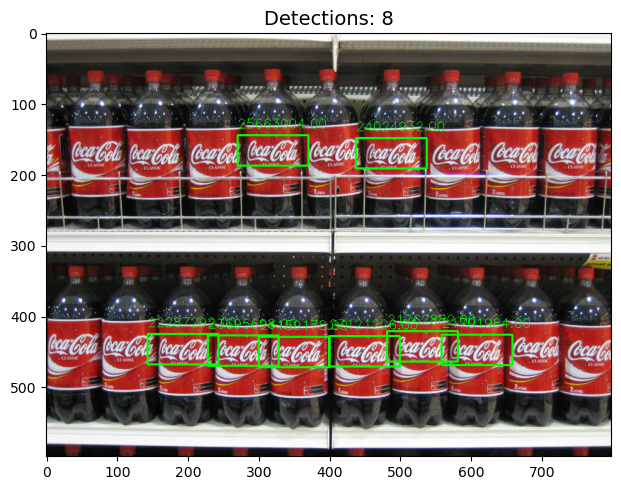

In [25]:
match_template_multiple_detections(multi_img, template)

### 3. Generalizar el algoritmo del item 2 para todas las imágenes

Adaptamos el método anterior para que funcione en todas las imágenes. Para eso iteramos probando distintas escalas como hicimos en el punto 1.

In [26]:
def match_template_multiple_detections_v2(img: np.ndarray, template: np.ndarray, method: str = 'TM_CCOEFF', threshold: float = 0.8) -> None:
    """
    Itera por distintas escalas para encontrar la mejor escala y luego busca múltiples detecciones del template en la imagen.

    :param img: Imagen en la cual se quiere detectar el template
    :type img: np.ndarray
    :param template: Template a detectar en la imagen
    :type template: np.ndarray
    :param method: Método a aplicar para matchTemplate. Por defecto TM_CCORR_NORMED
    :type method: str
    :param threshold: Umbral para filtrar las coincidencias, entre 0 y 1. Por defecto 0.8
    :type threshold: float
    """

    # conviertimos el template a escala de grises y aplicamos Canny
    template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    template_edges = cv.Canny(template_gray, 100, 200, L2gradient=True)

    # conviertimos la imagen a escala de grises
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # definimos las escalas
    h_image, w_image, _ = img.shape
    h_template, w_template = template_edges.shape

    max_scale = 4.0
    min_scale = max(h_template / h_image, w_template / w_image)
    scales = np.linspace(min_scale, max_scale, 100)

    best_results = []

    # iteramos sobre todas las escalas para encontrar la mejor escala
    for scale in scales:

        # escalamos y aplicamos Canny a la imagen
        img_scaled = cv.resize(img_gray, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
        img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)

        # aplicamos matchTemplate y buscamos el mejor resultado
        result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
        _, max_val, _, max_loc = cv.minMaxLoc(result)

        if not best_results or max_val > best_results[0]:
            best_results = [max_val, max_loc, (template_edges.shape), scale]

    # usamos la mejor escala para buscar múltiples detecciones
    best_scale = best_results[3]
    img_scaled = cv.resize(img_gray, (0, 0), fx=best_scale, fy=best_scale, interpolation=cv.INTER_LINEAR)
    img_edges = cv.Canny(img_scaled, 100, 200, L2gradient=True)

    # aplicamos matchTemplate con la mejor escala
    result = cv.matchTemplate(img_edges, template_edges, eval(f'cv.{method}'))
    locs = np.where(result >= best_results[0] * threshold)

    all_boxes = []
    all_scores = []
    h_template, w_template = template_edges.shape

    # almacenamos las cajas y las puntuaciones
    for loc in zip(*locs[::-1]):
        x1, y1 = loc
        x2, y2 = x1 + w_template, y1 + h_template
        all_boxes.append((x1, y1, x2, y2))
        all_scores.append(result[y1, x1])

    # aplicamos NMS para remover duplicados
    keep_indices = non_maximum_suppression(all_boxes, all_scores)

    # dibujamos las detecciones finales
    img_plot = img.copy()
    for idx in keep_indices:
        x1, y1, _, _ = all_boxes[idx]
        score = all_scores[idx]

        # gráficamos el recuadro
        match = [score, (x1, y1), (template_edges.shape), best_scale]
        img_plot = mark_template(img_plot, match)
        
    # gráficamos la imagen con todas las detecciones
    show_images([img_plot], [f'Total Detections: {len(keep_indices)}'])


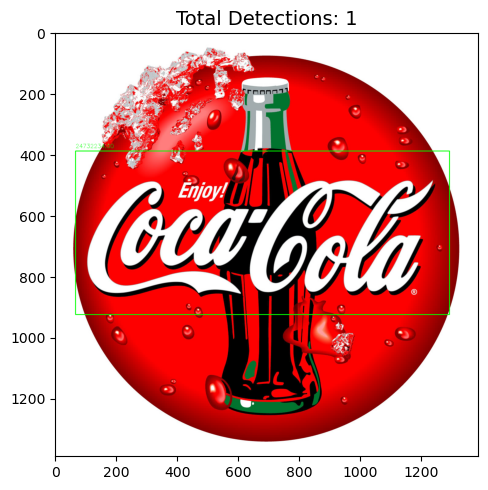

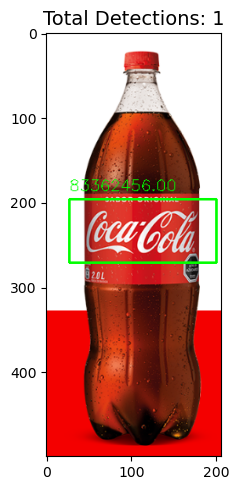

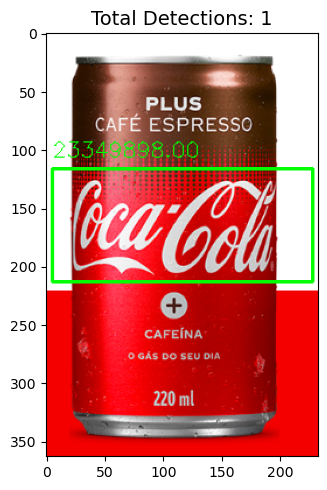

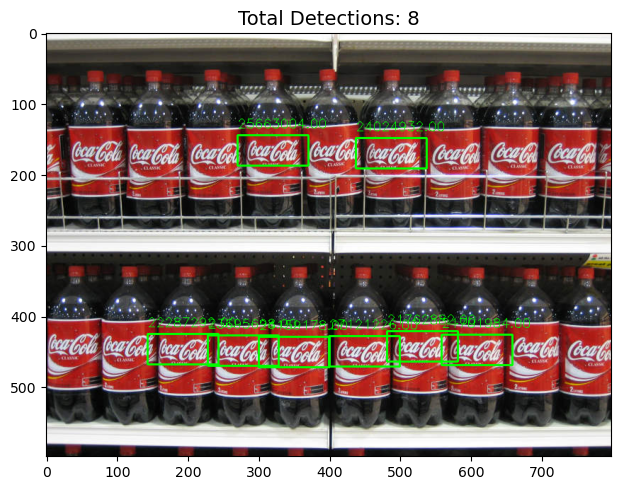

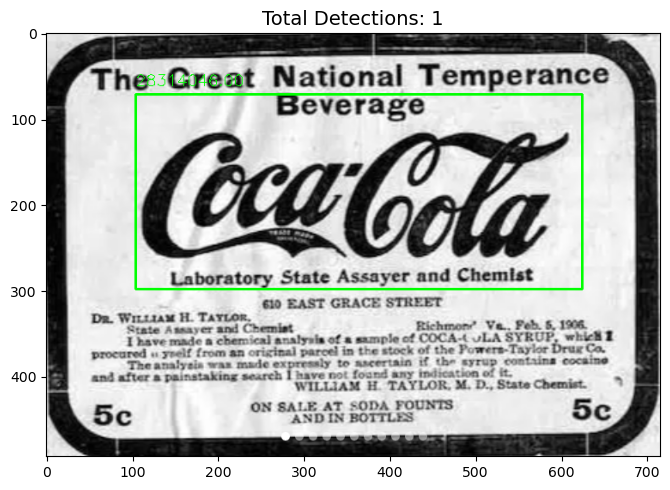

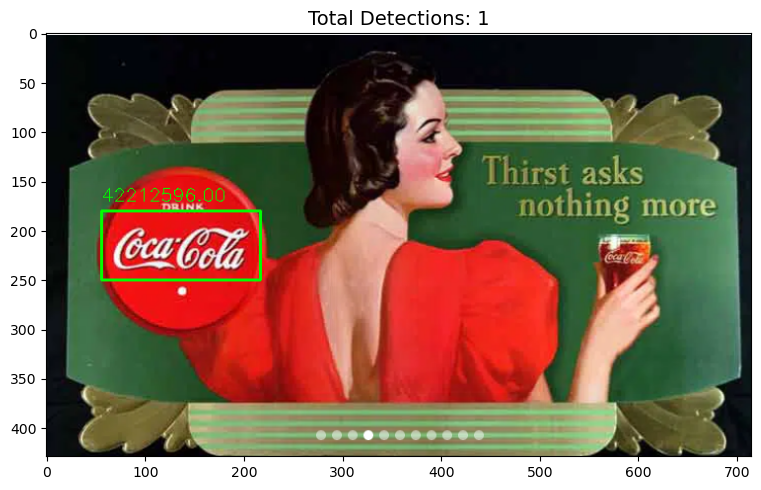

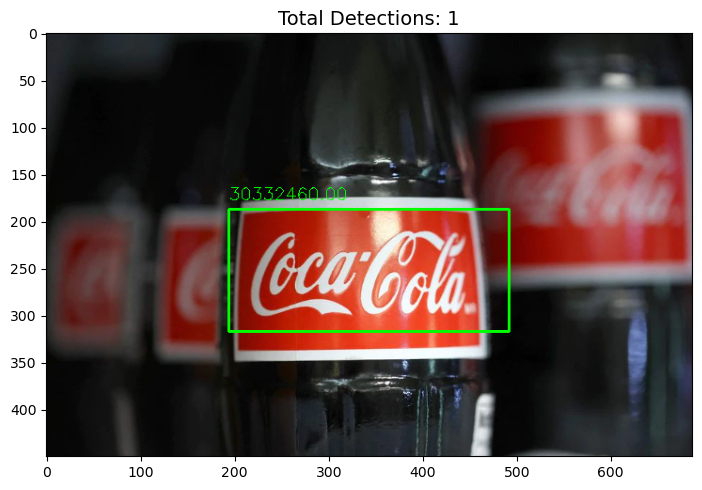

In [27]:
for img in images:
     match_template_multiple_detections_v2(img, template)